In [1]:
import sys

sys.path.append("../../../../XRaySimulation2")

import numpy as np
import matplotlib.pyplot as plt
from XRaySimulation import util, Pulse, Crystal, Alignment, Efficiency, RockingCurve

In [2]:
Ec = 9.831 * 2  # keV
wavelength = 2 * np.pi / util.kev_to_wavevec_length(Ec)

crystal_property = {'d': 0.34839 * 1e-4,
                    "chi0": complex(-0.25066E-05 ,     0.10009E-07 ),
                    "chih_sigma": complex(0.81922E-07 ,     -0.25836E-08  ),
                    "chihbar_sigma": complex(0.81922E-07 ,     -0.25836E-08  ),
                    "chih_pi": complex(0.77852E-10 ,     -0.31219E-10  ),
                    "chihbar_pi": complex(0.77852E-10 ,     -0.31219E-10 )}

myChannelCut = Crystal.ChannelCut(crystal_type="Silicon",
                                  miller_index="999",
                                  energy_keV=Ec,
                                  thickness_list=np.array([1e6, 1e6]),
                                  gap=1e3,
                                  surface_center_offset=2e4,
                                  edge_length_list=np.array([5e4, 5e4]),
                                  asymmetry_angle_list=np.deg2rad(np.array([0., 0.])),
                                  first_surface_loc="lower left",
                                  source="None",
                                  crystal_property=crystal_property, )

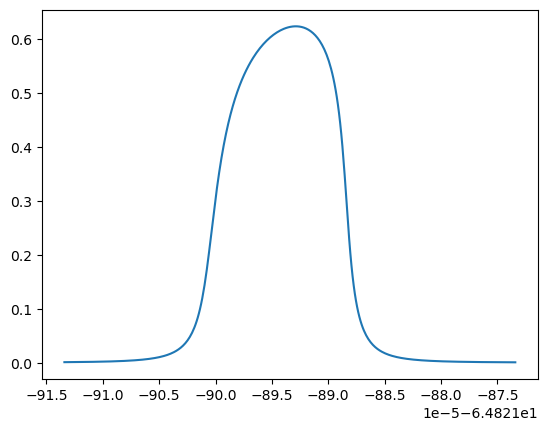

In [3]:
kin_c = np.array([0, 0, util.kev_to_wavevec_length(Ec)])

# Get array of kin to calculate the reflectivity curve
energy_num = 1000
deltaE = 10e-3 * 1e-3  # keV
energy_list = np.linspace(Ec - deltaE / 2, Ec + deltaE / 2, num=energy_num)
kin_array = np.zeros([energy_num, 3])
kin_array[:, 2] = util.kev_to_wavevec_length(energy_list)

# Align the channel-cut to this photon energy
(rot_mat,
 fwhm,
 kout,
 angle_adjust,
 angles,
 reflectivity) = Alignment.align_crystal_around_axis(crystal=myChannelCut,
                                    kin=kin_c,
                                    initial_angle=-util.get_bragg_angle(wave_length=wavelength,
                                                                        plane_distance=crystal_property['d']),
                                    rotation_axis=np.array([1., 0, 0]), 
                                    bandwidth_keV=0.001e-3 * 1e-3,
                                    fwhm_center=True,
                                    polarization='s',
                                    rot_center=None,
                                    rot_crystal=True,
                                    iteration=4)

# Get the energy acceptance
plt.plot(np.rad2deg(angles), reflectivity)
plt.show()

The angular acceptance is 0.20 urad or 3.49 ndeg
The energy bandwidth is 1.85 meV


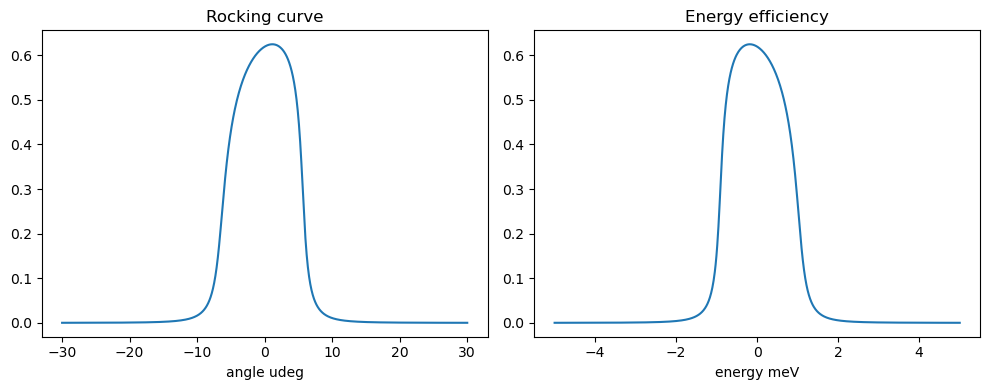

In [4]:
# Get the rocking curve for the angular acceptance
(angle_scan,
 reflect_sigma,
 reflect_pi,
 b_list,
 kout_2) = RockingCurve.get_rocking_curve_channelcut_around_axis(kin=kin_c,
                                                                 rotation_axis=np.array([1., 0, 0]),
                                                                 channelcut=myChannelCut,
                                                                 scan_range = [np.deg2rad(-3e-5),
                                                                               np.deg2rad(3e-5),],
                                                                 scan_number = 1000,
                                                                )
delta_theta, _, theta_idx = util.get_fwhm(coordinate=angle_scan,
                                          curve_values=np.square(np.abs(reflect_sigma)),
                                          center=True,
                                          get_index=True)
print("The angular acceptance is {:.2f} urad or {:.2f} ndeg".format(delta_theta * 1e6,
                                                                    np.deg2rad(delta_theta) * 1e9))

# Get the reflecitivity curve for the energy bandwidth
(total_efficiency_holder,
 efficiency_holder, 
 kout_holder) = Efficiency.get_crystal_reflectivity(device_list = myChannelCut.crystal_list,
                                                    kin_list = kin_array)
delta_energy, _, energy_idx = util.get_fwhm(coordinate=energy_list,
                                          curve_values=total_efficiency_holder,
                                          center=True,
                                          get_index=True)
print("The energy bandwidth is {:.2f} meV".format(delta_energy * 1e6,))

# Show the plot
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(np.rad2deg(angle_scan) * 1e6, np.square(np.abs(reflect_sigma)))
axes[0].set_xlabel("angle udeg")
axes[0].set_title("Rocking curve")

axes[1].plot((energy_list - Ec) * 1e6, total_efficiency_holder)
axes[1].set_xlabel("energy meV")
axes[1].set_title("Energy efficiency")

plt.tight_layout()
plt.show()